In [33]:
!pip install arch

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import ks_2samp, skew, kurtosis
from scipy.fft import fft, ifft
from scipy.stats import t

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, Flatten, Reshape, BatchNormalization, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [35]:
df = pd.read_csv('bitcoin_data_2020_2024_1h.csv', parse_dates=['datetime'], index_col='datetime')
df = df.sort_index()
df.tail()

<ipython-input-35-b33962fd16ee>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('bitcoin_data_2020_2024_1h.csv', parse_dates=['datetime'], index_col='datetime')


,price
datetime,
2024-11-19 20:00:00,92515.09375
2024-11-19 21:00:00,92405.70313
2024-11-19 22:00:00,92362.09375
2024-11-19 23:00:00,NaN
2024-11-20 00:00:00,92202.09375


In [36]:
df = df.dropna()
df.tail()

,price
datetime,
2024-11-19 19:00:00,93268.92969
2024-11-19 20:00:00,92515.09375
2024-11-19 21:00:00,92405.70313
2024-11-19 22:00:00,92362.09375
2024-11-20 00:00:00,92202.09375


In [37]:
log_returns = np.log(df['price'] / df['price'].shift(1)).dropna()
log_returns.tail()

,price
datetime,
2024-11-19 19:00:00,-0.005817
2024-11-19 20:00:00,-0.008115
2024-11-19 21:00:00,-0.001183
2024-11-19 22:00:00,-0.000472
2024-11-20 00:00:00,-0.001734


Method 1: AR Model

In [38]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(log_returns)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

model = ARIMA(log_returns, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

synthetic_returns_ar = model_fit.simulate(nsimulations=len(log_returns))

synthetic_prices_ar = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_ar))

ADF Statistic: -32.750153361463006
p-value: 0.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                36373
Model:                 ARIMA(1, 0, 0)   Log Likelihood              131078.803
Date:                Sun, 15 Dec 2024   AIC                        -262151.606
Time:                        17:41:45   BIC                        -262126.101
Sample:                             0   HQIC                       -262143.496
                              - 36373                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         5.4e-05   3.52e-05      1.534      0.125    -1.5e-05       0.000
ar.L1          0.0136      0.003      5.128      0.000       0.008       0.019
sigma2      4.339e-05      1e-07    433.723      0.0

ARIMA Model

In [39]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(log_returns, order=(1, 0, 1))
arima_fit = arima_model.fit()
print(arima_fit.summary())

synthetic_returns_arima = arima_fit.simulate(nsimulations=len(log_returns))

synthetic_prices_arima = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_arima))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                36373
Model:                 ARIMA(1, 0, 1)   Log Likelihood              131082.026
Date:                Sun, 15 Dec 2024   AIC                        -262156.051
Time:                        17:41:51   BIC                        -262122.045
Sample:                             0   HQIC                       -262145.239
                              - 36373                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.364e-05   3.51e-05      1.528      0.126   -1.52e-05       0.000
ar.L1         -0.4734      0.148     -3.193      0.001      -0.764      -0.183
ma.L1          0.4872      0.147      3.308      0.0

Method 2: Generating with GARCH

In [40]:
garch_model = arch_model(log_returns, vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

simulated_data = garch_model.simulate(garch_fit.params, nobs=len(log_returns))
synthetic_returns_garch = simulated_data['data']

synthetic_prices_garch = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_garch))

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.339e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                137169.
Distribution:                  Normal   AIC:                          -274329.
Method:            Maximum Likelihood   BIC:                          -274295.
                                        No. Observations:                36373
Date:                Sun, Dec 15 2024   Df Residuals:                    36372
Time:                        17:41:52   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.4045e-05  2.661e-05      2.031  4.225e-02 [1.

GARCH - Student's t-Distribution

In [41]:
from arch import arch_model

log_returns_scaled = log_returns * 100

garch_model_t = arch_model(log_returns_scaled, vol='GARCH', p=2, q=1, dist='StudentsT')
garch_fit_t = garch_model_t.fit(disp='off')

print(garch_fit_t.summary())

simulated_data_t = garch_model_t.simulate(garch_fit_t.params, nobs=len(log_returns_scaled))

synthetic_returns_garch_t = simulated_data_t['data'] / 100

initial_price = df['price'].iloc[0]
synthetic_prices_garch_t = initial_price * np.exp(np.cumsum(synthetic_returns_garch_t))


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -23758.9
Distribution:      Standardized Student's t   AIC:                           47529.9
Method:                  Maximum Likelihood   BIC:                           47580.9
                                              No. Observations:                36373
Date:                      Sun, Dec 15 2024   Df Residuals:                    36372
Time:                              17:41:54   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1172: InitialValueWarning: Parameters are not consistent with a stationary model. Using the intercept
to initialize the model.

  warn(initial_value_warning, InitialValueWarning)


GARCH_t + LSTM

In [42]:
# -----------------------------------------------
# Method 2: GARCH_t with Deep Learning (LSTM for volatility)
# -----------------------------------------------

np.random.seed(42)
tf.random.set_seed(42)

log_returns_scaled = log_returns * 100

garch_model_t = arch_model(log_returns_scaled, vol='GARCH', p=2, q=1, dist='StudentsT')
garch_fit_t = garch_model_t.fit(disp='off')

standardized_residuals = garch_fit_t.std_resid
conditional_volatility = garch_fit_t.conditional_volatility

sequence_length = 50
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

volatility = conditional_volatility.values.reshape(-1, 1)
X_vol, y_vol = create_sequences(volatility, sequence_length)

split = int(0.8 * len(X_vol))
X_train_vol, X_test_vol = X_vol[:split], X_vol[split:]
y_train_vol, y_test_vol = y_vol[:split], y_vol[split:]

model_vol = Model()

inputs_vol = Input(shape=(sequence_length, 1))
x_vol = LSTM(50, activation='tanh')(inputs_vol)
outputs_vol = Dense(1)(x_vol)
model_vol = Model(inputs=inputs_vol, outputs=outputs_vol)
model_vol.compile(optimizer='adam', loss='mean_squared_error')

model_vol.fit(X_train_vol, y_train_vol, epochs=10, batch_size=32, verbose=1)

predicted_volatility = model_vol.predict(X_vol, verbose=0).flatten()

standardized_residuals = standardized_residuals[-len(predicted_volatility):]

synthetic_returns_dl_garch = predicted_volatility * standardized_residuals

synthetic_returns_dl_garch = synthetic_returns_dl_garch / 100

synthetic_prices_dl_garch = initial_price * np.exp(np.cumsum(synthetic_returns_dl_garch))

Epoch 1/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0178
Epoch 2/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0050
Epoch 3/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0045
Epoch 4/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0045
Epoch 5/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0045
Epoch 6/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0044
Epoch 7/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0044
Epoch 8/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0044
Epoch 9/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0044
Epoch 10/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0044


GARCH - GJR-GARCH Model

In [43]:
gjr_garch_model = arch_model(log_returns, vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
gjr_garch_fit = gjr_garch_model.fit(disp='off')
print(gjr_garch_fit.summary())

simulated_data_gjr = gjr_garch_model.simulate(gjr_garch_fit.params, nobs=len(log_returns))
synthetic_returns_gjr = simulated_data_gjr['data']

synthetic_prices_gjr = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_gjr))

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.339e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        price   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                142907.
Distribution:      Standardized Student's t   AIC:                          -285802.
Method:                  Maximum Likelihood   BIC:                          -285751.
                                              No. Observations:                36373
Date:                      Sun, Dec 15 2024   Df Residuals:                    36372
Time:                              17:43:05   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Method 3: Fourier Transform-Based Generation

In [44]:
fft_vals = fft(log_returns.values)

random_phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(fft_vals)))
synthetic_fft = np.abs(fft_vals) * random_phases

synthetic_returns_fft = np.real(ifft(synthetic_fft))

synthetic_returns_fft = synthetic_returns_fft[:len(log_returns)]

synthetic_prices_fft = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_fft))

Fourier Transform - IAAFT

In [45]:
import numpy as np
from scipy.fft import fft, ifft

def iaaft(original_data, n_iterations=100, convergence_threshold=1e-6):
    sorted_original = np.sort(original_data)
    surrogate = np.random.permutation(original_data)
    prev_diff = np.inf

    for i in range(n_iterations):
        surrogate_fft = fft(surrogate)

        original_fft = fft(original_data)
        surrogate_fft = np.abs(original_fft) * np.exp(1j * np.angle(surrogate_fft))

        surrogate = np.real(ifft(surrogate_fft))

        # ranks = surrogate.argsort()
        # surrogate[ranks] = sorted_original

        diff = (sum(surrogate) + sum(original_data))
        if np.abs(prev_diff - diff) < convergence_threshold:
            break
        prev_diff = diff

    return surrogate

In [46]:
synthetic_returns_iaaft = iaaft(log_returns.values)

synthetic_prices_iaaft = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_iaaft))

Mathod 4: Bootstrap Method

In [47]:
# # Calculate residuals
# residuals = log_returns - np.mean(log_returns)

# # Bootstrap residuals
# bootstrapped_residuals = np.random.choice(residuals, size=len(log_returns), replace=True)

# # Reconstruct synthetic returns
# synthetic_returns_bootstrap = bootstrapped_residuals + np.mean(log_returns)

# # Reconstruct synthetic price series
# synthetic_prices_bootstrap = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_bootstrap))


Final - Avg (GARCH_t & GJR_GARCH & DL_GARCH_t)

In [48]:
synthetic_returns_dl_garch_formatted = synthetic_returns_dl_garch.reset_index(drop=True)

min_length = min(len(synthetic_returns_dl_garch_formatted), len(synthetic_returns_garch_t))

synthetic_returns_dl_garch_formatted = synthetic_returns_dl_garch_formatted.iloc[:min_length]
synthetic_returns_garch_t_matched = synthetic_returns_garch_t.iloc[:min_length]
synthetic_returns_gjr_matched = synthetic_returns_gjr.iloc[:min_length]

synthetic_returns_average = 0.33333 * (synthetic_returns_dl_garch_formatted + synthetic_returns_garch_t_matched + synthetic_returns_gjr_matched)

synthetic_prices_average = df['price'].iloc[0] * np.exp(np.cumsum(synthetic_returns_average))

print(synthetic_returns_average)
print(len(synthetic_returns_average))

0       -0.003138
1        0.000674
2        0.004840
3       -0.001796
4        0.003269
           ...   
36318   -0.000183
36319   -0.007260
36320    0.002600
36321    0.001419
36322    0.000690
Length: 36323, dtype: float64
36323


Evaluation Metrics

In [49]:
def evaluate_metrics(real_returns, synthetic_returns):
    metrics = {}
    metrics['Mean'] = (np.mean(real_returns), np.mean(synthetic_returns))
    metrics['Variance'] = (np.var(real_returns), np.var(synthetic_returns))
    metrics['Skewness'] = (skew(real_returns), skew(synthetic_returns))
    metrics['Kurtosis'] = (kurtosis(real_returns), kurtosis(synthetic_returns))
    metrics['Autocorrelation'] = (pd.Series(real_returns).autocorr(), pd.Series(synthetic_returns).autocorr())
    ks_statistic, ks_pvalue = ks_2samp(real_returns, synthetic_returns)
    metrics['KS Statistic'] = ks_statistic
    metrics['KS p-value'] = ks_pvalue
    return metrics

synthetic_returns_methods = {
    'AR': synthetic_returns_ar,
    'GARCH': synthetic_returns_garch,
    'FFT': synthetic_returns_fft,
    # 'IAAFT': synthetic_returns_iaaft,
    'ARIMA': synthetic_returns_arima,
    'GARCH_t': synthetic_returns_garch_t,
    'GARCH_t_LSTM': synthetic_returns_dl_garch,
    'GJR-GARCH': synthetic_returns_gjr,
    'AVG_DL_GARCH': synthetic_returns_average,
    # 'Bootstrap': synthetic_returns_bootstrap
}

for method, synthetic in synthetic_returns_methods.items():
    metrics = evaluate_metrics(log_returns.values, synthetic)
    print(f'\nEvaluation Metrics for {method} Method:')
    for metric, values in metrics.items():
        if isinstance(values, tuple):
            print(f'{metric} - Real: {values[0]:.6f}, Synthetic: {values[1]:.6f}')
        else:
            print(f'{metric}: {values:.6f}')


Evaluation Metrics for AR Method:
Mean - Real: 0.000054, Synthetic: 0.000068
Variance - Real: 0.000043, Synthetic: 0.000043
Skewness - Real: -0.350058, Synthetic: 0.002340
Kurtosis - Real: 18.855910, Synthetic: 0.029115
Autocorrelation - Real: 0.013631, Synthetic: 0.028002
KS Statistic: 0.120886
KS p-value: 0.000000

Evaluation Metrics for GARCH Method:
Mean - Real: 0.000054, Synthetic: 0.000003
Variance - Real: 0.000043, Synthetic: 0.000045
Skewness - Real: -0.350058, Synthetic: 0.126245
Kurtosis - Real: 18.855910, Synthetic: 4.612818
Autocorrelation - Real: 0.013631, Synthetic: 0.007614
KS Statistic: 0.105160
KS p-value: 0.000000

Evaluation Metrics for FFT Method:
Mean - Real: 0.000054, Synthetic: -0.000038
Variance - Real: 0.000043, Synthetic: 0.000022
Skewness - Real: -0.350058, Synthetic: -0.007210
Kurtosis - Real: 18.855910, Synthetic: 0.010066
Autocorrelation - Real: 0.013631, Synthetic: 0.011656
KS Statistic: 0.073489
KS p-value: 0.000000

Evaluation Metrics for ARIMA Method:

Storing in Excel

In [50]:
synthetic_returns_methods = {
    'AR': synthetic_returns_ar,
    'GARCH': synthetic_returns_garch,
    'FFT': synthetic_returns_fft,
    # 'IAAFT': synthetic_returns_iaaft,
    'ARIMA': synthetic_returns_arima,
    'GARCH_t': synthetic_returns_garch_t,
    'GARCH_t_LSTM': synthetic_returns_dl_garch,
    'GJR-GARCH': synthetic_returns_gjr,
    'AVG_DL_GARCH': synthetic_returns_average
    # 'Bootstrap': synthetic_returns_bootstrap
}

def evaluate_metrics(real_returns, synthetic_returns):
    metrics = {}
    metrics['Mean'] = (np.mean(real_returns), np.mean(synthetic_returns))
    metrics['Variance'] = (np.var(real_returns), np.var(synthetic_returns))
    metrics['Skewness'] = (skew(real_returns), skew(synthetic_returns))
    metrics['Kurtosis'] = (kurtosis(real_returns), kurtosis(synthetic_returns))
    metrics['Autocorrelation'] = (pd.Series(real_returns).autocorr(), pd.Series(synthetic_returns).autocorr())
    ks_statistic, ks_pvalue = ks_2samp(real_returns, synthetic_returns)
    metrics['KS Statistic'] = ks_statistic
    metrics['KS p-value'] = ks_pvalue
    return metrics

metrics_list = []

for method, synthetic in synthetic_returns_methods.items():
    metrics = evaluate_metrics(log_returns.values, synthetic)
    flattened_metrics = {'Method': method}
    for metric_name, metric_value in metrics.items():
        if isinstance(metric_value, tuple):
            flattened_metrics[f'{metric_name} Real'] = metric_value[0]
            flattened_metrics[f'{metric_name} Synthetic'] = metric_value[1]
        else:
            flattened_metrics[metric_name] = metric_value
    metrics_list.append(flattened_metrics)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Method', inplace=True)

synthetic_prices_methods = {
    'AR': synthetic_prices_ar,
    'GARCH': synthetic_prices_garch,
    'FFT': synthetic_prices_fft,
    # 'IAAFT': synthetic_prices_iaaft,
    'ARIMA': synthetic_prices_arima,
    'GARCH_t': synthetic_prices_garch_t,
    'GARCH_t_LSTM': synthetic_prices_dl_garch,
    'GJR-GARCH': synthetic_prices_gjr,
    'AVG_DL_GARCH': synthetic_prices_average
    # 'Bootstrap': synthetic_prices_bootstrap
}

dates = df.index[1:]

with pd.ExcelWriter('synthetic_prices_and_metrics.xlsx') as writer:
    for method_name, synthetic_prices in synthetic_prices_methods.items():
        synthetic_prices = np.array(synthetic_prices)

        if len(dates) != len(synthetic_prices):
            print(f"Skipping {method_name}: Length mismatch between dates and prices.")
            continue

        synthetic_prices_df = pd.DataFrame({
            'datetime': dates,
            'price': synthetic_prices
        })
        synthetic_prices_df.set_index('datetime', inplace=True)
        synthetic_prices_df.to_excel(writer, sheet_name=method_name)

    metrics_df.to_excel(writer, sheet_name='Summary')

Skipping GARCH_t_LSTM: Length mismatch between dates and prices.
Skipping AVG_DL_GARCH: Length mismatch between dates and prices.


Visualization

In [51]:
!pip install statsmodels
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


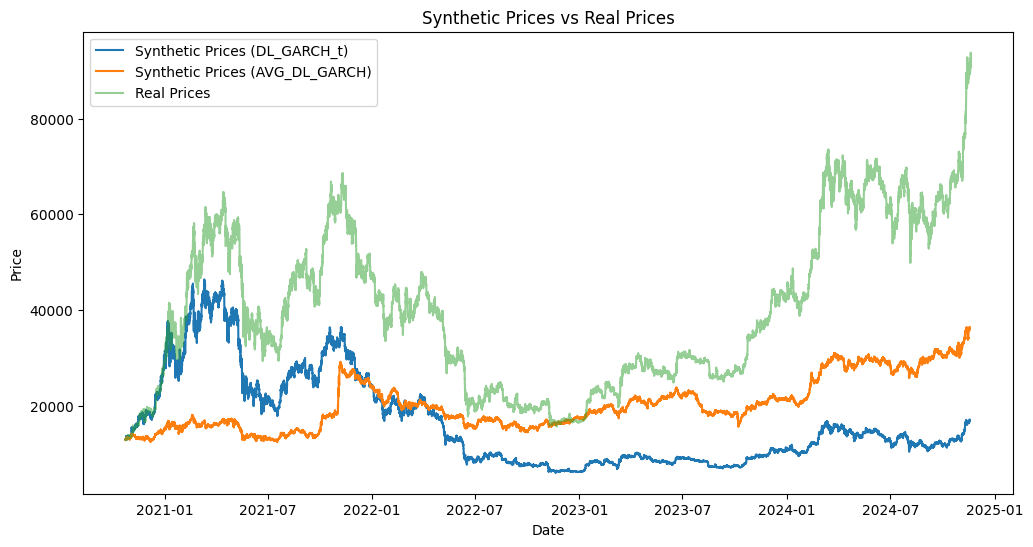

In [60]:
plt.figure(figsize=(12,6))
# plt.plot(df.index[:len(synthetic_prices_garch_t)], synthetic_prices_garch_t, label='Synthetic Prices (GARCH_t)')
plt.plot(df.index[:len(synthetic_prices_dl_garch)], synthetic_prices_dl_garch, label='Synthetic Prices (DL_GARCH_t)')
plt.plot(df.index[:len(synthetic_prices_average)], synthetic_prices_average, label='Synthetic Prices (AVG_DL_GARCH)')
plt.plot(df.index, df['price'], label='Real Prices', alpha=0.5)
plt.legend()
plt.title('Synthetic Prices vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

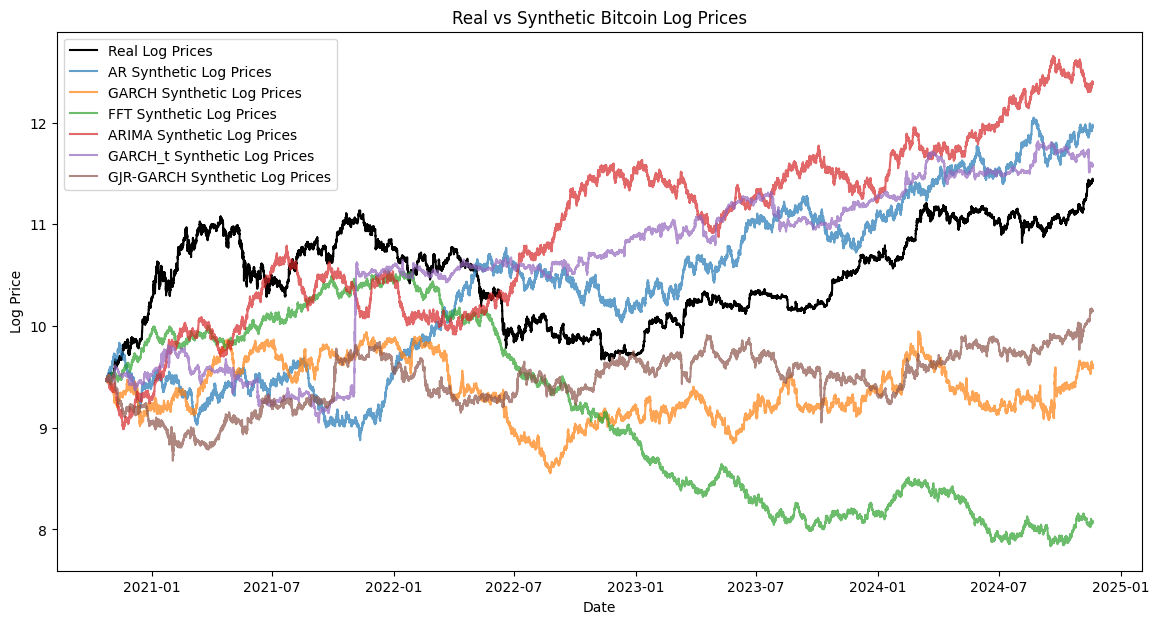

In [53]:
df['log_price'] = np.log(df['price'])

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['log_price'], label='Real Log Prices', color='black')

for method_name, synthetic_prices in synthetic_prices_methods.items():
    if method_name == 'GARCH_t_LSTM' or method_name == 'AVG_DL_GARCH':
        continue
    log_synthetic_prices = np.log(synthetic_prices)
    plt.plot(dates, log_synthetic_prices, label=f'{method_name} Synthetic Log Prices', alpha=0.7)

plt.title('Real vs Synthetic Bitcoin Log Prices')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend()
plt.show()


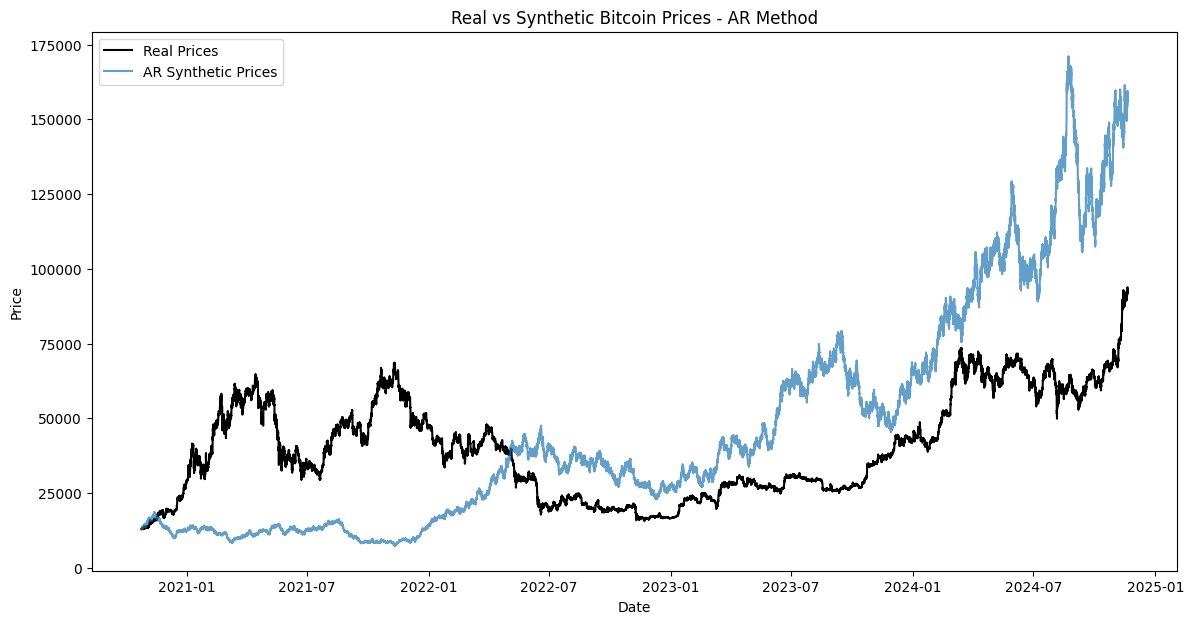

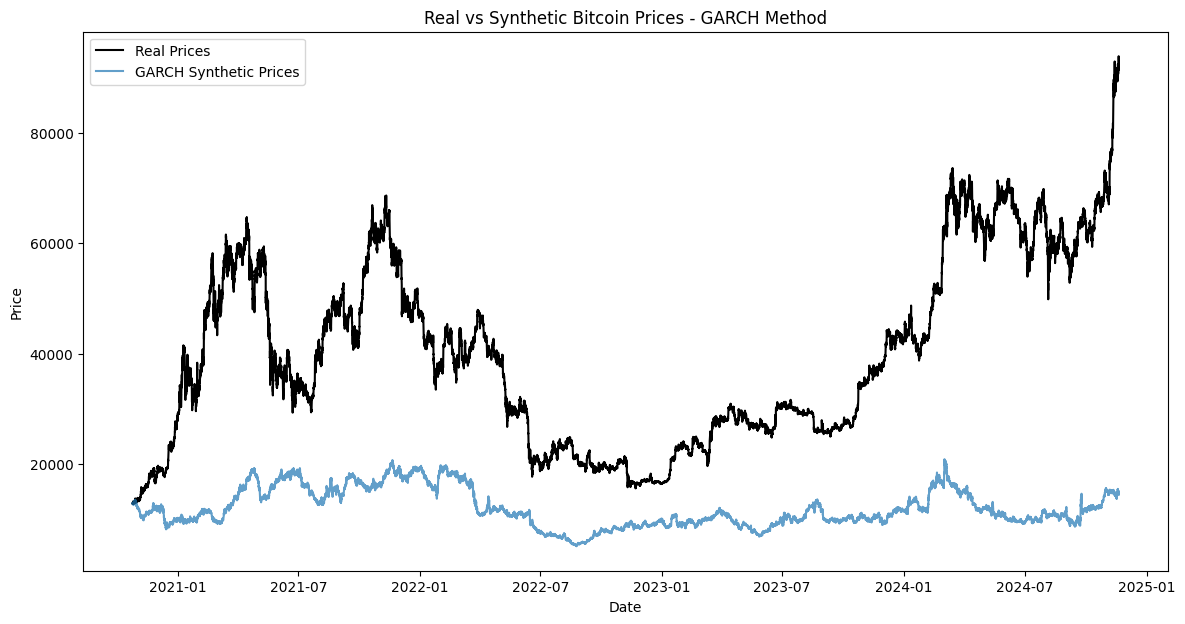

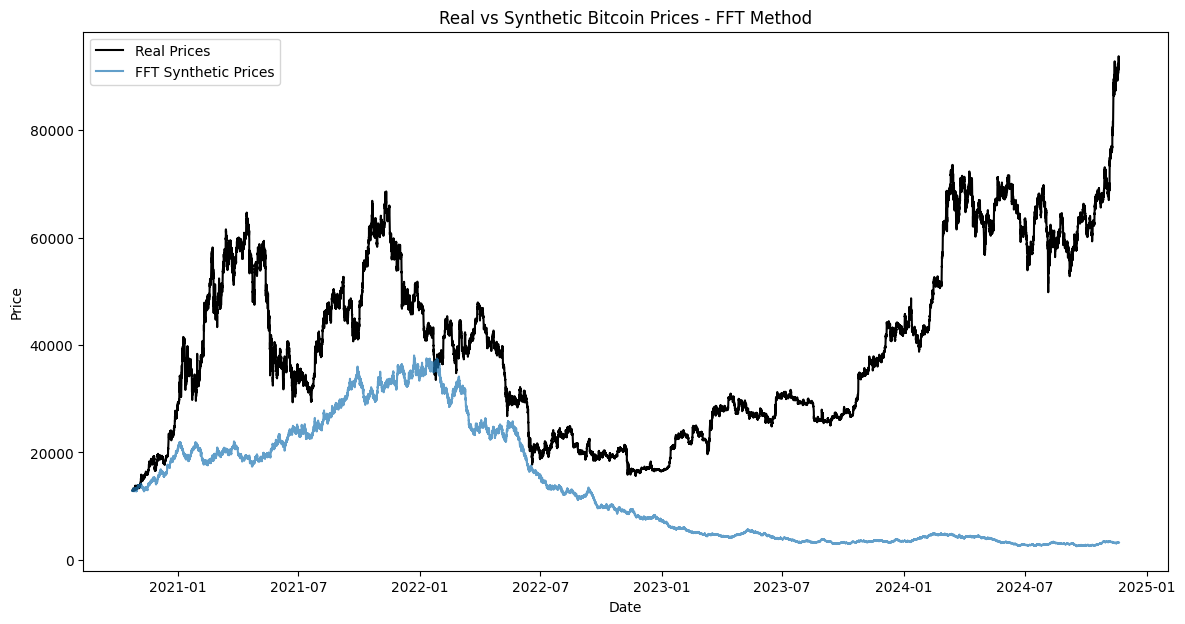

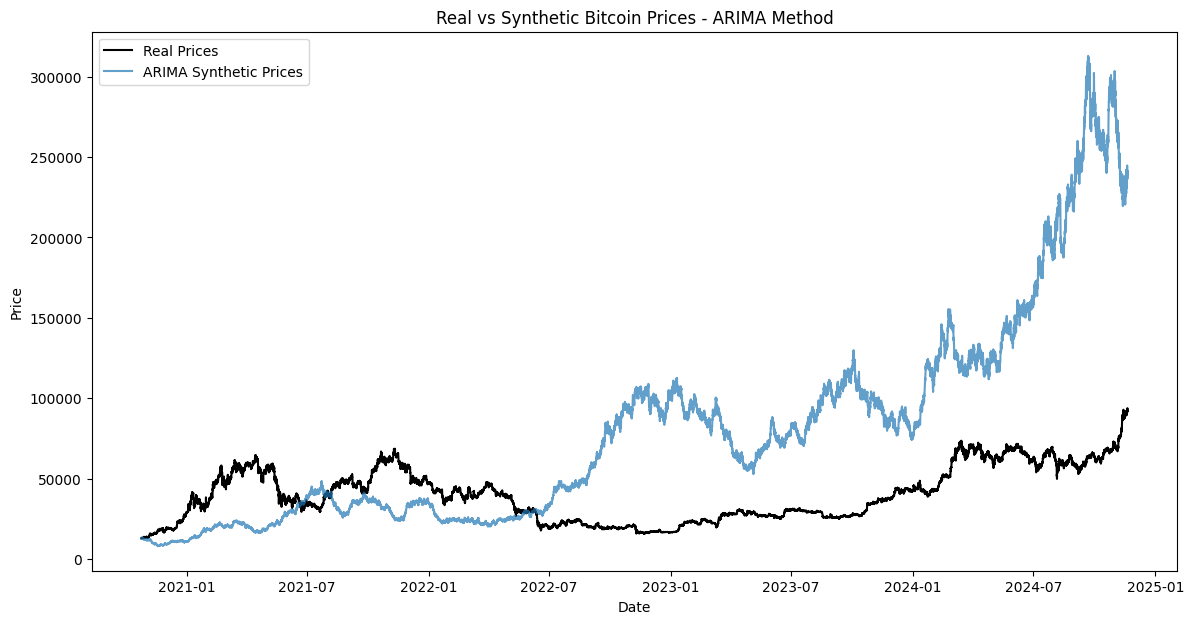

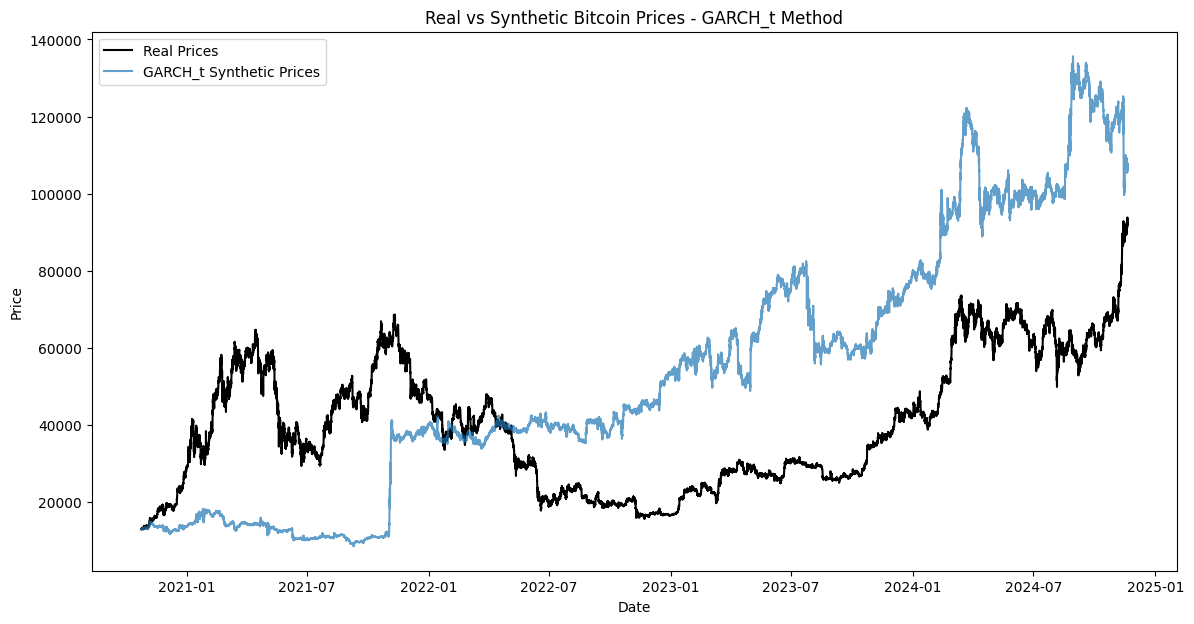

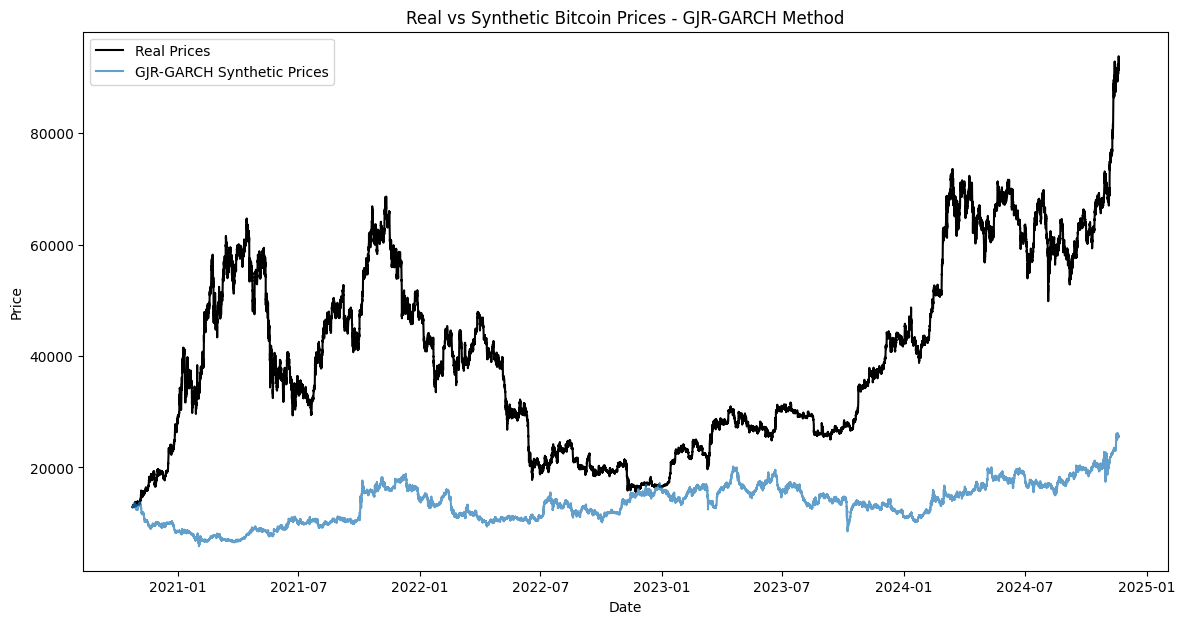

In [54]:
for method_name, synthetic_prices in synthetic_prices_methods.items():
    if method_name == 'GARCH_t_LSTM' or method_name == 'AVG_DL_GARCH':
        continue
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['price'], label='Real Prices', color='black')
    plt.plot(dates, synthetic_prices, label=f'{method_name} Synthetic Prices', alpha=0.7)
    plt.title(f'Real vs Synthetic Bitcoin Prices - {method_name} Method')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


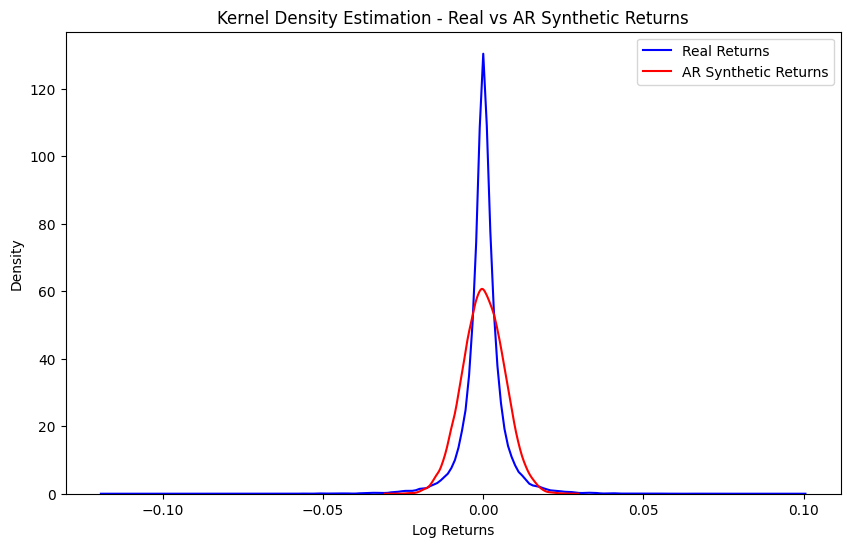

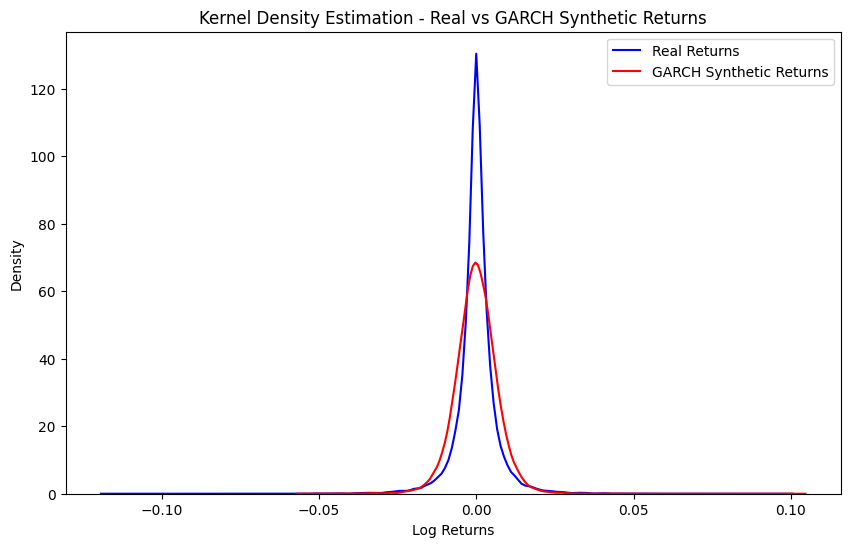

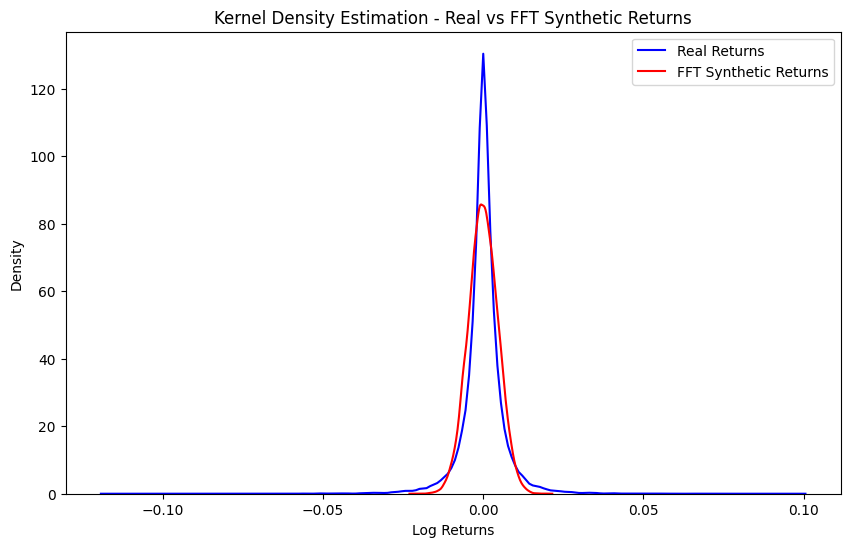

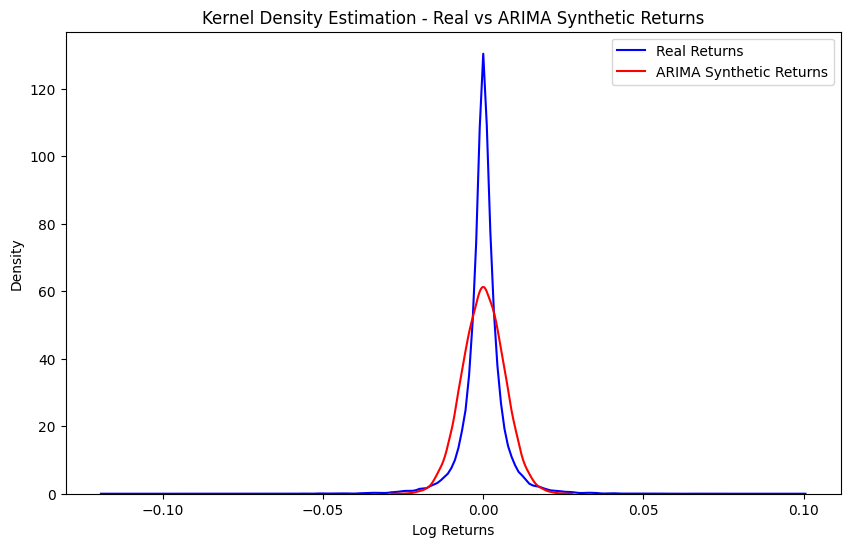

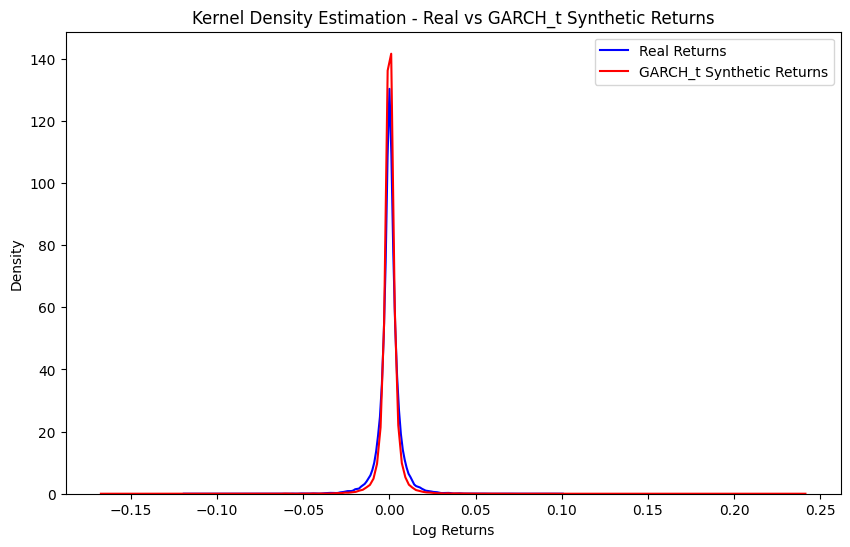

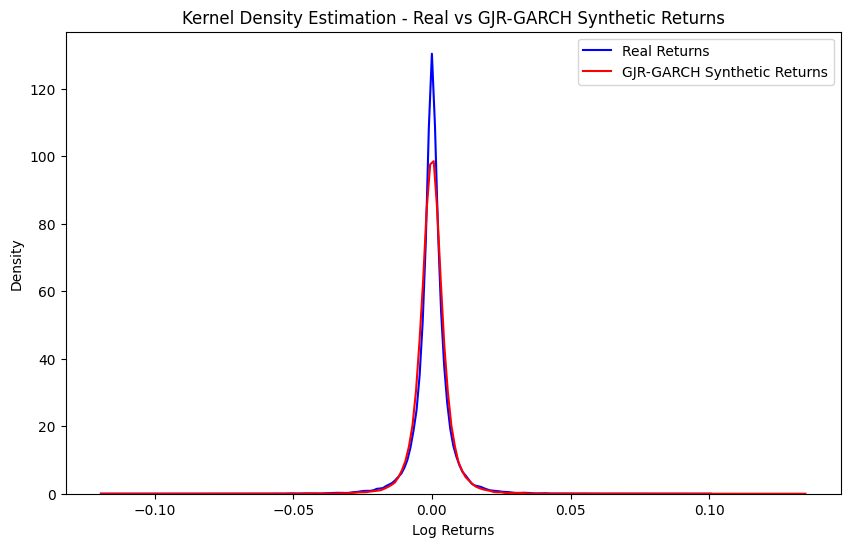

In [55]:
for method_name, synthetic_returns in synthetic_returns_methods.items():
    if method_name == 'GARCH_t_LSTM' or method_name == 'AVG_DL_GARCH':
        continue
    plt.figure(figsize=(10, 6))
    sns.kdeplot(log_returns, label='Real Returns', color='blue')
    sns.kdeplot(synthetic_returns, label=f'{method_name} Synthetic Returns', color='red')
    plt.title(f'Kernel Density Estimation - Real vs {method_name} Synthetic Returns')
    plt.xlabel('Log Returns')
    plt.legend()
    plt.show()


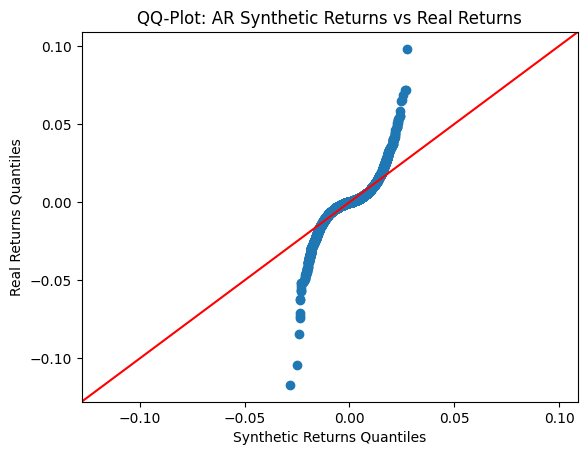

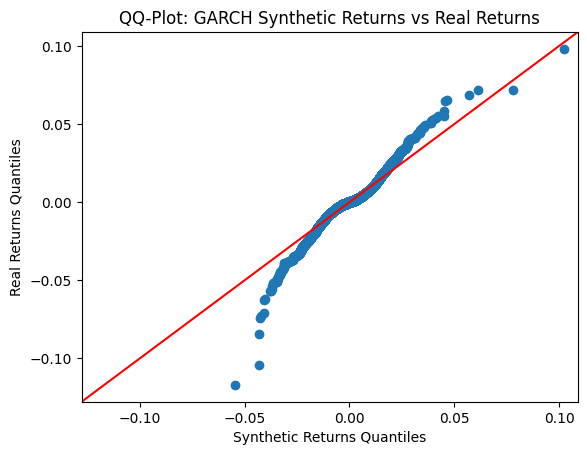

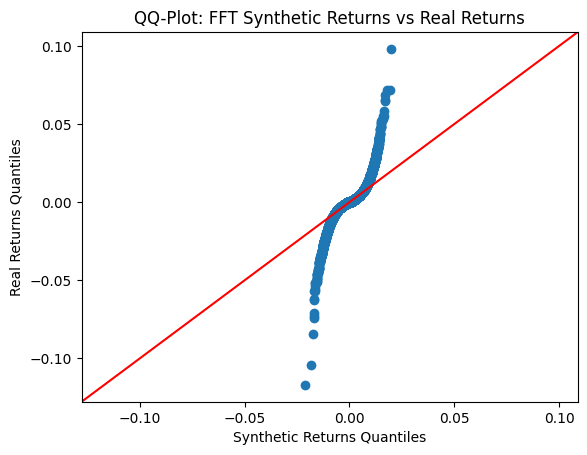

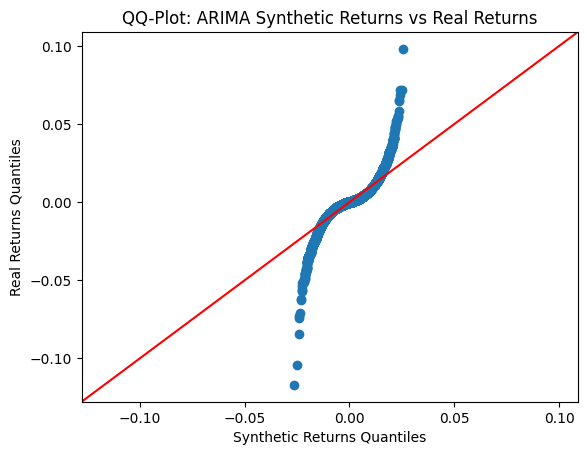

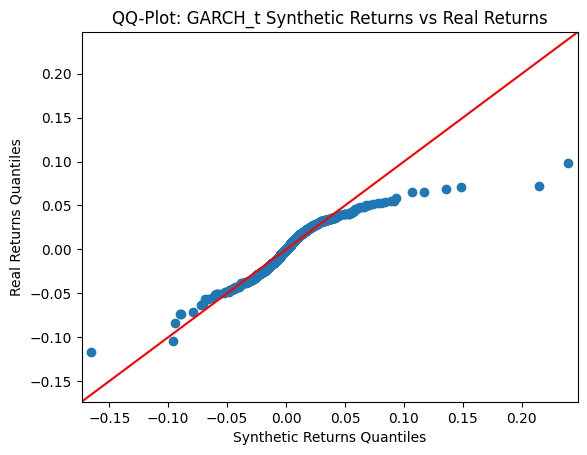

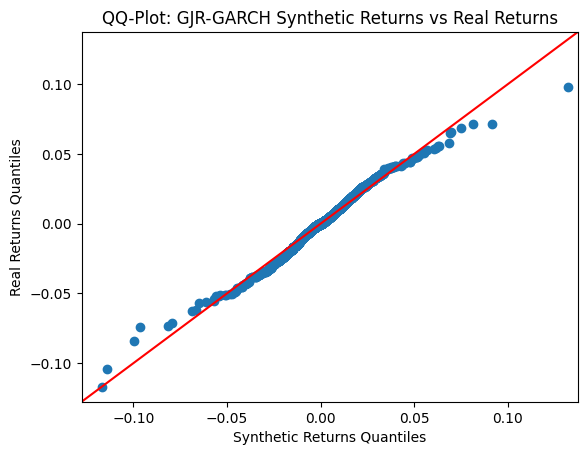

In [56]:
for method_name, synthetic_returns in synthetic_returns_methods.items():
    if method_name == 'GARCH_t_LSTM' or method_name == 'AVG_DL_GARCH':
        continue
    sm.qqplot_2samples(synthetic_returns, log_returns.values, line='45')
    plt.title(f'QQ-Plot: {method_name} Synthetic Returns vs Real Returns')
    plt.xlabel('Synthetic Returns Quantiles')
    plt.ylabel('Real Returns Quantiles')
    plt.show()


In [57]:
metrics_df_reset = metrics_df.reset_index()

metrics_melted = metrics_df_reset.melt(id_vars='Method', var_name='Metric', value_name='Value')

metrics_melted['Type'] = metrics_melted['Metric'].apply(lambda x: 'Real' if 'Real' in x else ('Synthetic' if 'Synthetic' in x else 'Other'))
metrics_melted['Metric'] = metrics_melted['Metric'].str.replace(' Real', '').str.replace(' Synthetic', '')

metrics_pivot = metrics_melted.pivot_table(index=['Method', 'Metric'], columns='Type', values='Value').reset_index()

metrics_pivot.fillna(0, inplace=True)


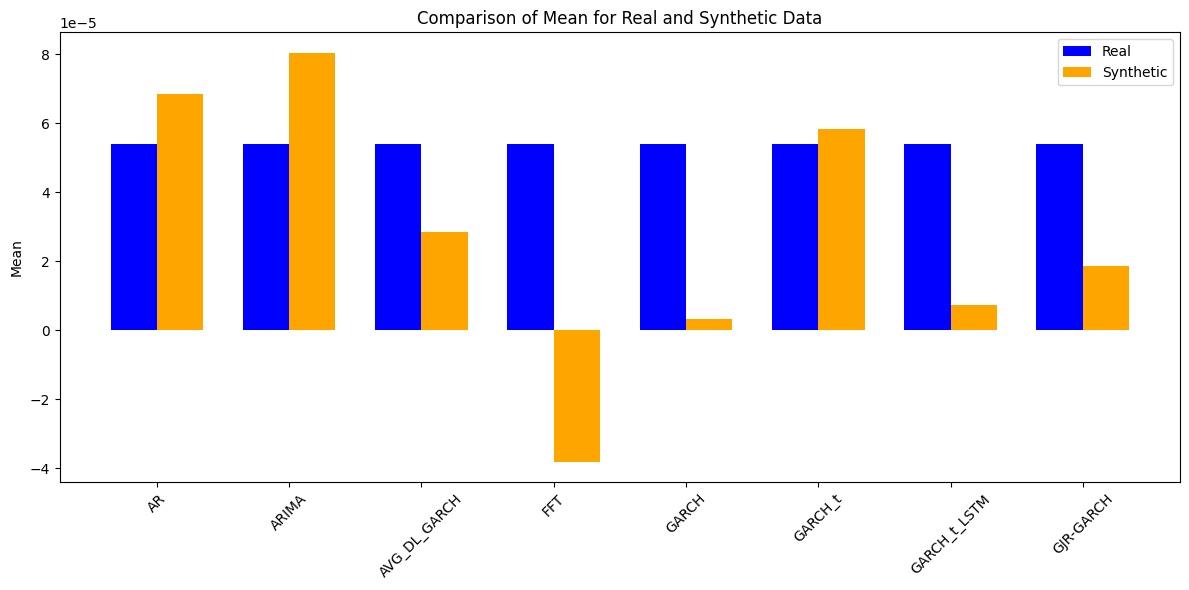

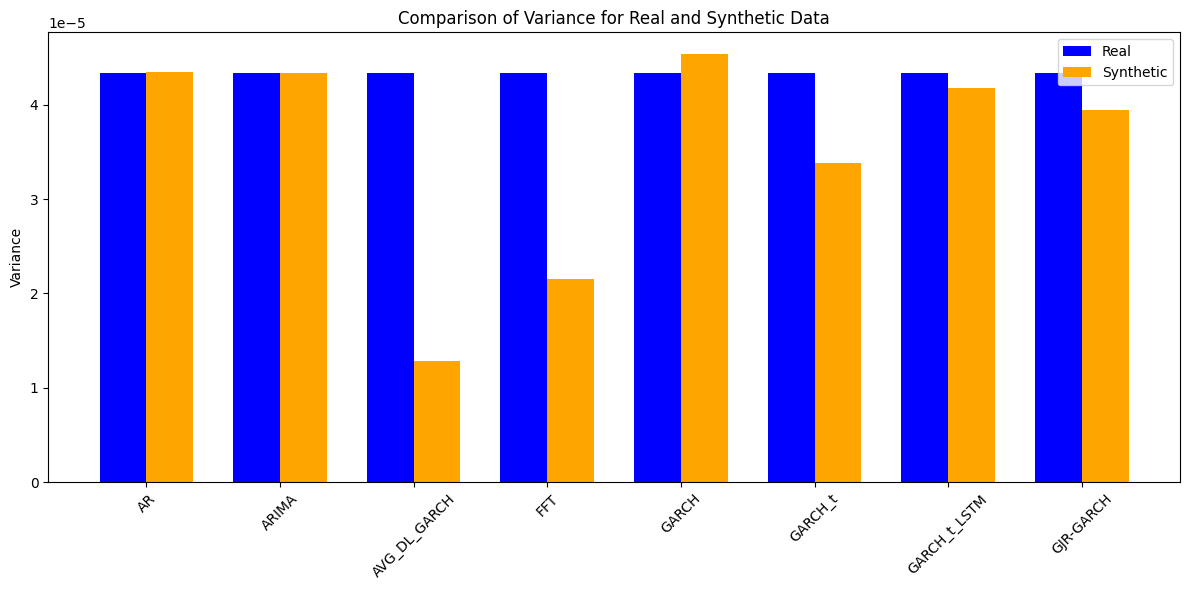

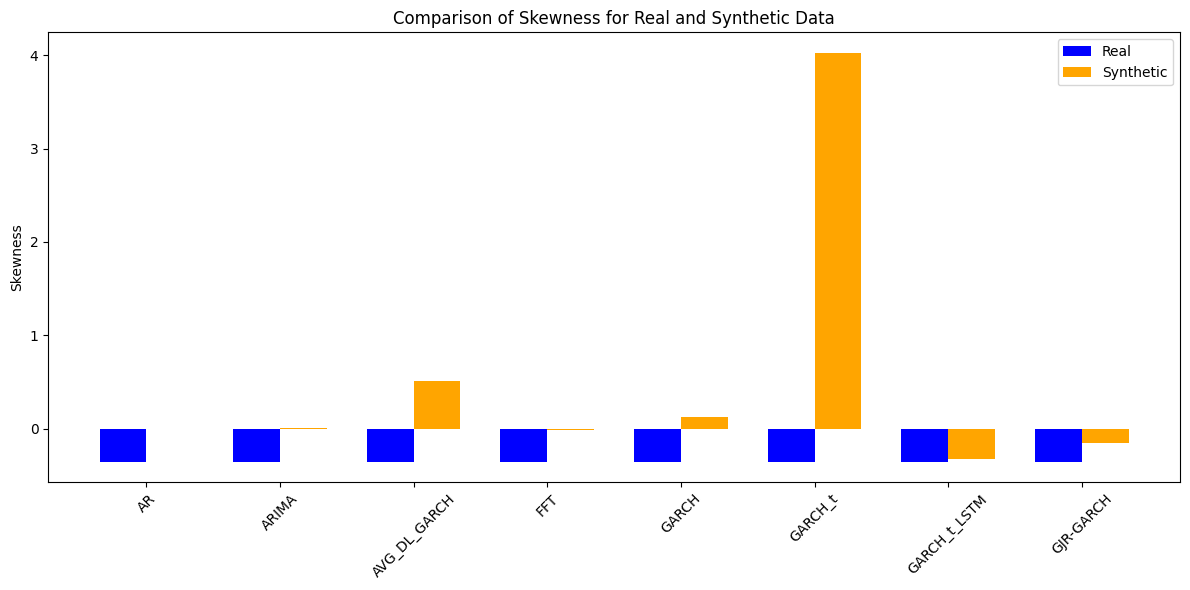

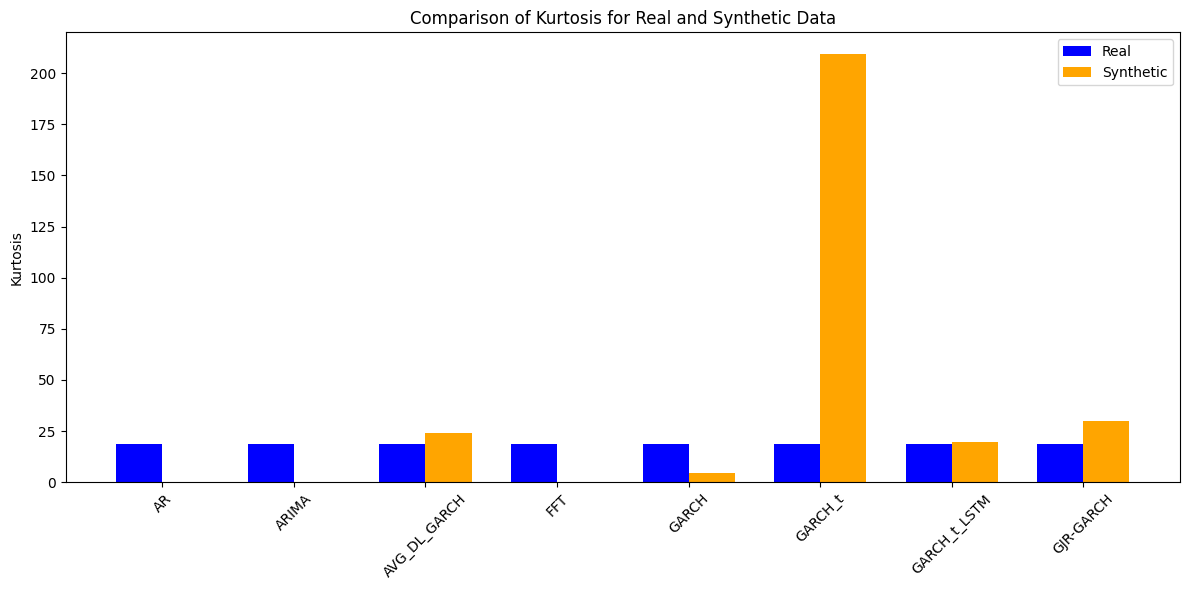

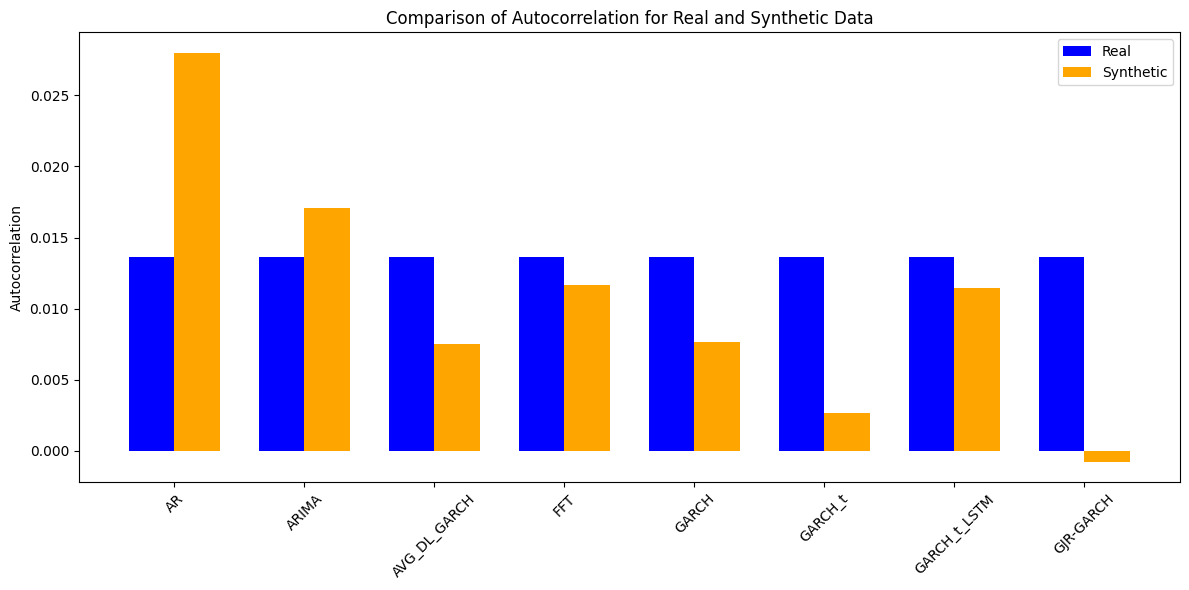

In [58]:
metrics_to_plot = ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Autocorrelation']

for metric in metrics_to_plot:
    data = metrics_pivot[metrics_pivot['Metric'] == metric]
    x = np.arange(len(data['Method']))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, data['Real'], width, label='Real', color='blue')
    plt.bar(x + width/2, data['Synthetic'], width, label='Synthetic', color='orange')
    plt.xticks(x, data['Method'], rotation=45)
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Real and Synthetic Data')
    plt.legend()
    plt.tight_layout()
    plt.show()
